# Attribute Importance for Concept Drift - Primary and Secondary Drift Detection in one dataset

This notebook allows to detect primary and related secondary driftpoints according to the master thesis' framework.

The user specifies a file path for the dataset to analyze and builds the primary as well as secondary drift detectors.

Outputs are graphs as well as drift point lists.

## Setup
### Imports

In [84]:
# imports
import helper
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import pop_comparison
from processdrift.framework import windowing
import math
import pandas as pd

### Data settings and event log loading

In [85]:
# data settings
data_file_path = 'data/synthetic/attribute_drift/sudden_3_attribute_values/10000/cf10k_0bbd4c9b-97ca-4594-ad55-32d3686e7756.xes' # + 'data\\synthetic\\maardji et al 2013_xes_attributes\\logs\\cb\\cb2.5k.xes' # 

# load event log
event_log = xes_importer.apply(data_file_path)

parsing log, completed traces :: 100%|██████████| 10000/10000 [00:07<00:00, 1299.66it/s]


### Configure Primary Drift Detector

In [86]:
# # alternative 1: ProDrift Drift detector
# primary_process_drift_detector = drift_detection.DriftDetectorProDrift(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
#                                                                         drift_detection_mechanism='runs',
#                                                                         window_size=200,
#                                                                         window_mode='adaptive',
#                                                                         detect_gradual_as_well=False)

In [87]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

# primary_feature_extractor = feature_extraction.RelationshipTypesCountFeatureExtractor('Relationship types count')
# primary_window_generator = windowing.FixedSizeWindowGenerator(window_size=150, slide_by=1)
# primary_population_comparer = pop_comparison.HotellingsTSquaredPopComparer()
# primary_threshold = 0.5
# primary_process_drift_detector = drift_detection.DriftDetector(primary_feature_extractor, 
#                                                                primary_window_generator,
#                                                                primary_population_comparer, 
#                                                                threshold=primary_threshold)

In [88]:
# alternative 3: drift detector true known
primary_process_drift_detector = drift_detection.DriftDetectorTrueKnown(helper.get_change_points_maardji_et_al_2013(len(event_log)))

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [89]:
window_size = 200
slide_by = 10
secondary_window_generator = windowing.AdaptiveWindowGenerator(window_size, slide_by=slide_by)
secondary_population_comparer = pop_comparison.ChiSquaredComparer()
secondary_threshold = 0.05
secondary_exclude_attributes = ['concept:name']
max_distance = 300

phi = math.ceil(window_size / slide_by / 2)
rho = 1
print(f"phi={phi}, rho={rho}")

change_point_extractor = drift_detection.PhiFilterChangePointExtractor(secondary_threshold, phi, rho)

secondary_drift_detectors = drift_detection.get_all_attribute_drift_detectors(event_log,
                                                                         secondary_window_generator, 
                                                                         secondary_population_comparer, 
                                                                         exclude_attributes=secondary_exclude_attributes,
                                                                         change_point_extractor=change_point_extractor)

phi=10, rho=1


## Run the Change Point Explainer

In [90]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
primary_and_secondary_changes = drift_explainer.get_primary_and_secondary_changes(event_log, max_distance=max_distance)

In [91]:
# import cProfile
# cProfile.run('drift_explainer.get_primary_and_secondary_changes(event_log, max_distance=max_distance)', 'profile.txt')
# 
# import pstats
# p = pstats.Stats("profile.txt")
# p.sort_stats(pstats.SortKey.CUMULATIVE)
# p.print_stats()

In [92]:
threshold = 0.05
phi = 2
rho = 2

change_series = pd.Series([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])
display(change_series)

change_point_extractor = drift_detection.PhiFilterChangePointExtractor(threshold, phi, rho)
change_point_extractor.get_change_points(change_series)

0     1
1     1
2     1
3     0
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    1
dtype: int64

[3]

<AxesSubplot:>

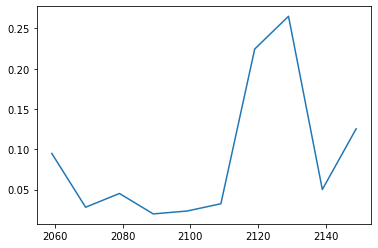

In [93]:
primary_and_secondary_changes[1]['irrelevant_attribute_02']['change_series'].loc[2050:2150].plot()

In [94]:
change_point_extractor.get_change_points(primary_and_secondary_changes[1]['irrelevant_attribute_02']['change_series'].loc[2050:2150])

[2069]

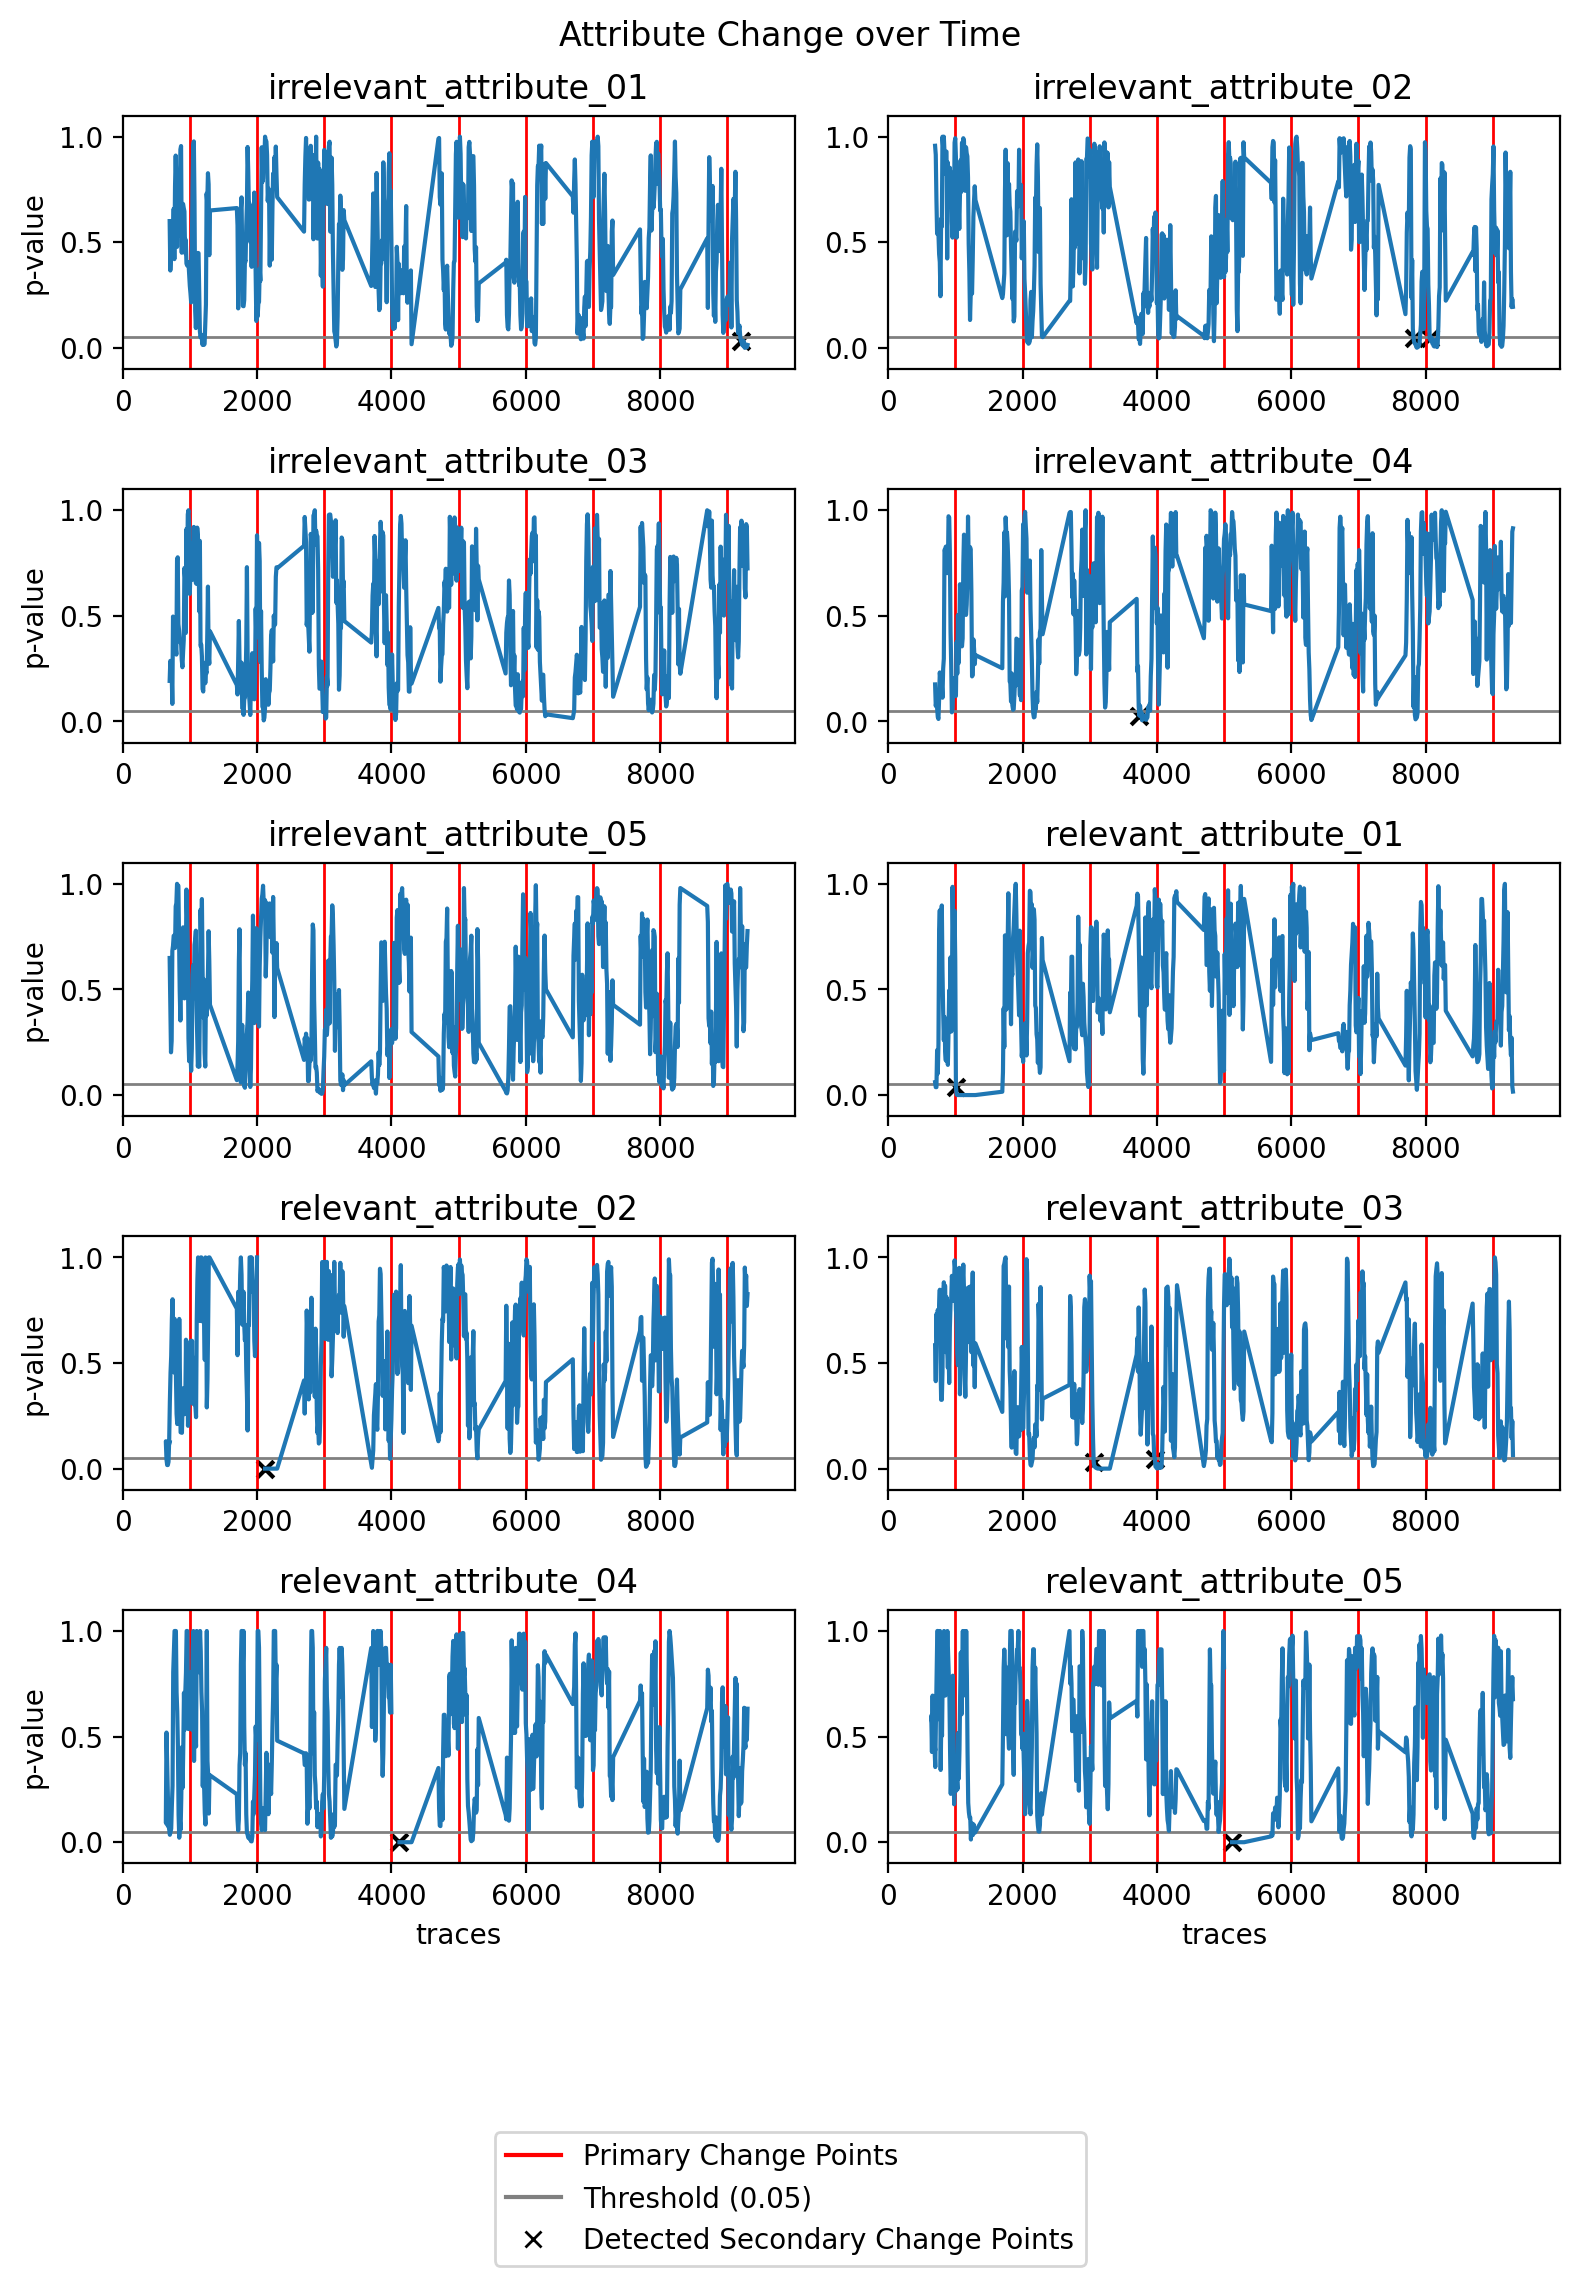

In [95]:
# plot the change point explanations
drift_explanation.plot_primary_and_secondary_changes(primary_and_secondary_changes)
pass

In [96]:
primary_and_secondary_changes[1]['relevant_attribute_04']['change_series'].loc[3800:4200]

KeyError: 3800

In [ ]:
drift_explanation.get_possible_change_explanations(primary_and_secondary_changes, max_distance=200)

{1000: [{'detector': 'relevant_attribute_01',
   'change_point': 1009,
   'distance': 9}],
 2000: [],
 3000: [],
 4000: [],
 5000: [],
 6000: [],
 7000: [],
 8000: [],
 9000: []}